In [1]:
import pandas as pd
online=pd.read_csv("OrderData.csv")

C:\Users\TatungSS\Anaconda3\envs\django\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
####把退貨資料排除在RFM資料之外
online=online[online["TotalSalesAmount"]>0]
online.head()

,TradesGroupCode,TradesDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,TsCount,Qty,TotalSalesAmount,TotalPrice,TotalDiscount,TotalPromotionDiscount,TotalCouponDiscount,TotalLoyaltyDiscount,Status,MemberID
0,TG190926B00185,2019-09-26 01:15:10.297,OfficialECom,MobileWeb,JKOPay,Home,1,1,680,680,0,0,0,0,Finish,JAE7ypAI%2BmBkMAd1REpPJI3zcEQBI9WBTeg5QlsEri4%3D
1,TG190926X00450,2019-09-26 21:16:59.167,OfficialECom,iOSApp,JKOPay,FamilyPickup,4,4,2660,2760,-100,0,-100,0,Finish,UB%2F0WwXAdW5GhwWmVB036mhSMcUnbK1IA5kXp31h4XQ%3D
2,TG190928M00620,2019-09-28 11:31:04.847,OfficialECom,MobileWeb,JKOPay,FamilyPickup,1,1,1016,1280,-264,-64,-200,0,Finish,rKUVLmkXyUqqVN8zU1UB40kuhBLRok8FvQtDZTGIS00%3D
3,TG190928U00383,2019-09-28 18:23:28.130,OfficialECom,iOSApp,JKOPay,FamilyPickup,1,1,1380,1480,-100,0,-100,0,Finish,WpUUri%2BOuznMIisbG5ramILffQkqoQr8TPOj0L8lqN8%3D
4,TG190929R00721,2019-09-29 15:29:56.730,OfficialECom,MobileWeb,JKOPay,FamilyPickup,1,1,1780,1880,-100,0,-100,0,Cancel,acrdzjptXw%2FDeckXY4b5R89lYb41BC0H0bEgiTo9Zj8%3D


In [3]:
print("總共有幾位顧客: ",len(pd.unique(online["MemberID"])))
print("總共有幾筆資料: ",online.shape[0])

總共有幾位顧客:  190320
總共有幾筆資料:  400242


In [4]:
#RFM
#最近一次消費（Recency）：指消費者至今再次購買與上次購買產品的時間差
#消費金額（Monetary）：指消費者在一定期間內購買該產品的總金額
#消費頻率（Frequency）：指消費者在一定期間內購買該產品的次數

In [5]:
from datetime import datetime 
import datetime as dt
online.TradesDateTime=online.TradesDateTime.apply(lambda x:x[:-4])
snapshot_date = pd.to_datetime(online.TradesDateTime).max() + dt.timedelta(days=1)
snapshot_date=datetime.strptime(str(snapshot_date), "%Y-%m-%d %H:%M:%S")
snapshot_date=pd.to_datetime(snapshot_date)
print(snapshot_date)

2020-05-01 23:58:29


In [6]:
datamart = online.groupby(['MemberID']).agg({
'TradesDateTime': lambda x: (snapshot_date-pd.to_datetime(x).max()).days,'TradesGroupCode': 'count',
'TotalSalesAmount': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns = {'TradesDateTime': 'Recency'
,'TradesGroupCode': 'Frequency',
'TotalSalesAmount': 'MonetaryValue'}, inplace=True)
datamart.head()

,Recency,Frequency,MonetaryValue
MemberID,,,
%2B%2B%2FsALKlNdkh585nb%2F9geIrN84FIZZLkD8qf909HvCU%3D,310,1,2850
%2B%2B2Sw%2FYbIovLROVPDc%2BeVjbEdn6fTeg7niPBE%2FeJJKo%3D,706,1,1380
%2B%2B3XVjBiQPLoAXWc7gK%2BTdvTH4J4AmgkeFlB3mmN7YY%3D,375,2,5240
%2B%2B44iA8rzzl4lYN3dzParPLqAXetHBSwDFIBUBD%2B%2Bt4%3D,240,1,1900
%2B%2B6Xs%2FwHblxbDDDYQ9osx6DMUooacHVpAJvv7KWgf3o%3D,1408,1,1280


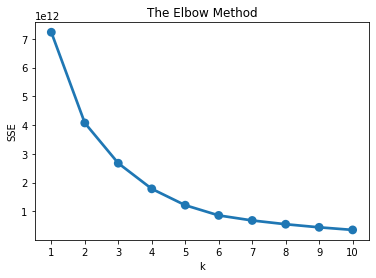

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster cente
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(datamart)
cluster_labels = kmeans.labels_
datamart_rfm_k4 = datamart.assign(Cluster = cluster_labels)
datamart_rfm_k4.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean','count']}).round(1)

Recency Frequency MonetaryValue        
           mean      mean          mean   count
Cluster                                        
0         361.1       5.7       12087.0   20557
1         768.7       1.5        2580.9  168267
2         165.7      19.9       44992.0    1480
3          23.5     124.8      286081.2      16

>Cluster 0 :There are some buying records for the customers in this group within this year, but according to the two variables of R and F, we can tell that they may become potential lost customers , and the company should find ways to recover them in order to reduce churn rate.
 

>Cluster 1 :On average, consumer hasn’t made a purchase for more than two years.Therefore,I suggest to skip them when we do further analysis.

>Cluster 2 :Consumers are still shopping within half of a year (and the previous shopping frequency is high),the company should  pay attention on them and stimulate them to spend again.


>Cluster 3:The customers can be said to be VVIP customers. R, F, and M are all super ideal, but only 10 people.

In [16]:
%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
datamart_rfm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
MemberID,,,,
%2B%2B%2FsALKlNdkh585nb%2F9geIrN84FIZZLkD8qf909HvCU%3D,310,1,2850,1
%2B%2B2Sw%2FYbIovLROVPDc%2BeVjbEdn6fTeg7niPBE%2FeJJKo%3D,706,1,1380,1
%2B%2B3XVjBiQPLoAXWc7gK%2BTdvTH4J4AmgkeFlB3mmN7YY%3D,375,2,5240,1
%2B%2B44iA8rzzl4lYN3dzParPLqAXetHBSwDFIBUBD%2B%2Bt4%3D,240,1,1900,1
%2B%2B6Xs%2FwHblxbDDDYQ9osx6DMUooacHVpAJvv7KWgf3o%3D,1408,1,1280,1


In [17]:
pd.value_counts(datamart_rfm_k4["Cluster"])

1    168267
0     20557
2      1480
3        16
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

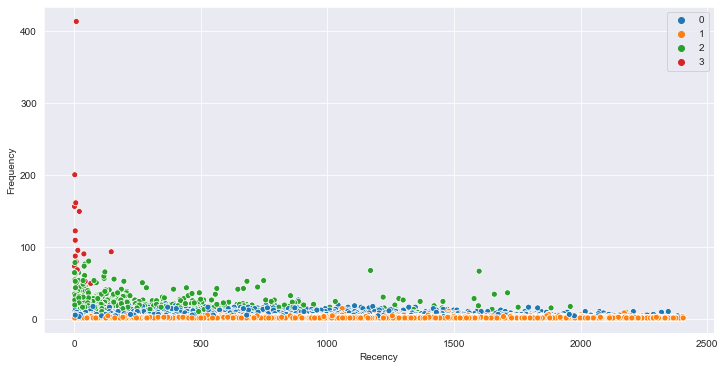

In [19]:
palette ={0:"C0",1:"C1",2:"C2",3:"C3"}
sns.scatterplot(x='Recency', y='Frequency', data=datamart_rfm_k4, hue=datamart_rfm_k4['Cluster'].tolist(),palette=palette)

<AxesSubplot:xlabel='Frequency', ylabel='MonetaryValue'>

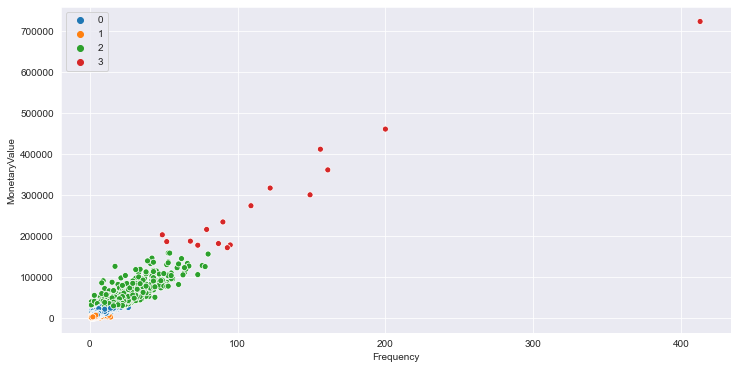

In [20]:
palette ={0:"C0",1:"C1",2:"C2",3:"C3"}
sns.scatterplot(x='Frequency', y='MonetaryValue', data=datamart_rfm_k4, hue=datamart_rfm_k4['Cluster'].tolist(), palette=palette)

<AxesSubplot:xlabel='MonetaryValue', ylabel='Recency'>

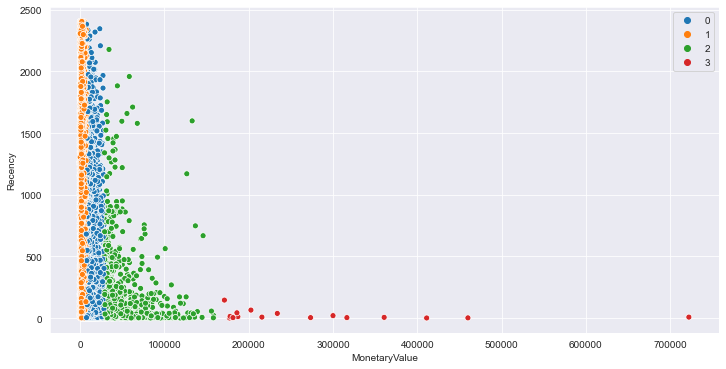

In [21]:
palette ={0:"C0",1:"C1",2:"C2",3:"C3"}
sns.scatterplot(x='MonetaryValue', y='Recency', data=datamart_rfm_k4, hue=datamart_rfm_k4['Cluster'].tolist(), palette=palette)

In [22]:
rfm=pd.DataFrame(datamart_rfm_k4["Cluster"])
rfm.head()

,Cluster
MemberID,
%2B%2B%2FsALKlNdkh585nb%2F9geIrN84FIZZLkD8qf909HvCU%3D,1
%2B%2B2Sw%2FYbIovLROVPDc%2BeVjbEdn6fTeg7niPBE%2FeJJKo%3D,1
%2B%2B3XVjBiQPLoAXWc7gK%2BTdvTH4J4AmgkeFlB3mmN7YY%3D,1
%2B%2B44iA8rzzl4lYN3dzParPLqAXetHBSwDFIBUBD%2B%2Bt4%3D,1
%2B%2B6Xs%2FwHblxbDDDYQ9osx6DMUooacHVpAJvv7KWgf3o%3D,1


In [23]:
rfm.to_csv("rfm.csv")